In [ ]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
! pip install pyvirtualdisplay
! apt-get install -y xvfb python3-opengl ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 45.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.14).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np

import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import torch.distributions as D
from shutil import copyfile
import os

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
def get_action_dqn(network, state, epsilon, epsilon_decay, action_size):

  state = torch.tensor(state, dtype=torch.float32).to(device)
  possible_a = [torch.argmax(network(state.unsqueeze(0)), dim=1).item(), random.choice(list(range(action_size)))]
  probs = torch.tensor([1-epsilon, epsilon])
  d = torch.distributions.Categorical(probs)
  action = possible_a[d.sample()]

  return action, epsilon*epsilon_decay


def prepare_batch(memory, batch_size, state_size):

  states = []
  actions = []
  next_states = []
  rewards = []
  dones = []
  for state, action, next_state, reward, done in memory:
    states.append(state)
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward)
    dones.append(done)

  return (
    torch.tensor(states, dtype=torch.float32),
    torch.tensor(actions, dtype=torch.long),
    torch.tensor(next_states, dtype=torch.float32),
    torch.tensor(rewards, dtype=torch.float32),
    torch.tensor(dones, dtype=torch.bool)
    )


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):


  state = batch[0].to(device)
  action = batch[1].to(device)
  next_state = batch[2].to(device)
  reward = batch[3].to(device)
  done = batch[4].to(device)
  batch_size = state[0].shape[0]

  with torch.no_grad():

    q = target_network(next_state).max(1)[0]
    y = reward + gamma * q * (1.0 - done.float())

  loss = torch.nn.functional.mse_loss(q_network(state).gather(1, action.unsqueeze(1)).squeeze(1), y)
  optim.zero_grad()
  loss.backward()
  optim.step()

  if not global_step % target_update:
    target_network.load_state_dict(q_network.state_dict())



In [21]:
import random
import pygame

SCREEN_WIDTH = 1100

class Obstacle:
    WIDTH = 40
    HEIGHT = 40

    def __init__(self, x, y):
        self.rect = pygame.Rect(x, y, self.WIDTH, self.HEIGHT)

    def update(self, speed):
        self.rect.x -= speed


class SmallCactus(Obstacle):
    def __init__(self):
        y = 325
        x = SCREEN_WIDTH
        super().__init__(x, y)


class LargeCactus(Obstacle):
    def __init__(self):
        y = 300
        x = SCREEN_WIDTH
        super().__init__(x, y)


class Bird(Obstacle):
    def __init__(self):
        y = 250
        x = SCREEN_WIDTH
        super().__init__(x, y)


class Dinosaur:
    X_POS = 80
    Y_POS = 310
    Y_POS_DUCK = 340
    JUMP_VEL = 8.5
    WIDTH = 40
    HEIGHT = 40

    def __init__(self):
        self.rect = pygame.Rect(self.X_POS, self.Y_POS, self.WIDTH, self.HEIGHT)
        self.jump_vel = self.JUMP_VEL
        self.is_jumping = False
        self.is_ducking = False

    def update(self, action):
        if action == "jump" and not self.is_jumping:
            self.is_jumping = True
            self.is_ducking = False
        elif action == "duck" and not self.is_jumping:
            self.is_ducking = True
        elif action == "run":
            self.is_ducking = False

        if self.is_jumping:
            self.rect.y -= self.jump_vel * 4
            self.jump_vel -= 0.8
            if self.jump_vel < -self.JUMP_VEL:
                self.is_jumping = False
                self.jump_vel = self.JUMP_VEL
                self.rect.y = self.Y_POS
        elif self.is_ducking:
            self.rect.y = self.Y_POS_DUCK
        else:
            self.rect.y = self.Y_POS


class Env:
    def __init__(self):
        self.dino = Dinosaur()
        self.obstacle = None
        self.game_speed = 20
        self.done = False

    def reset(self):
        self.dino = Dinosaur()
        self.obstacle = self._spawn_obstacle()
        self.game_speed = 20
        self.done = False
        return self.get_state()

    def _spawn_obstacle(self):
        choice = random.choice(["small", "large", "bird"])
        if choice == "small":
            return SmallCactus()
        elif choice == "large":
            return LargeCactus()
        else:
            return Bird()

    def step(self, action):
        if self.done:
            return self.get_state(), 0, self.done, {}
        action_map = {0: "run", 1: "jump", 2: "duck"}
        action = action_map[action]


        self.dino.update(action)
        self.obstacle.update(self.game_speed)

        reward = 1.0
        dist = self.obstacle.rect.x - self.dino.rect.x
        BASE_REACT_THRESHOLD = 130
        NORMALIZE_SPEED = 10
        REACT_THRESHOLD = BASE_REACT_THRESHOLD * (self.game_speed / NORMALIZE_SPEED)

        if self.dino.rect.colliderect(self.obstacle.rect):
            reward = -100
            self.done = True
            return self.get_state(), reward, self.done, {}

        if self.obstacle.rect.right < self.dino.rect.left:
            if isinstance(self.obstacle, Bird) and action == "duck":
                reward += 10
            elif isinstance(self.obstacle, (SmallCactus, LargeCactus)) and action == "jump":
                reward += 10
            else:
                reward += 5
            self.obstacle = self._spawn_obstacle()
        else:
            if action == "jump":
              if isinstance(self.obstacle, (SmallCactus, LargeCactus)):
                  if dist > REACT_THRESHOLD:
                      reward -= 2
                  elif 105 < dist <= REACT_THRESHOLD:
                      reward += 5
              else:
                  reward -= 4
            elif action == "duck":
                if isinstance(self.obstacle, Bird):
                    if dist > REACT_THRESHOLD:
                        reward -= 2
                    elif 105 < dist <= REACT_THRESHOLD:
                        reward += 5
                else:
                    reward -= 5

        dist = self.obstacle.rect.x - self.dino.rect.x
        reward += max(0, 1.0 - dist / SCREEN_WIDTH)
        reward += self.game_speed * 0.01
        return self.get_state(), reward, self.done, {}

    def get_state(self):
        dist_to_obstacle = (self.obstacle.rect.x - self.dino.rect.x)  / SCREEN_WIDTH
        dino_y = self.dino.rect.y  / SCREEN_WIDTH
        obs_y = self.obstacle.rect.y  / SCREEN_WIDTH
        obs_width = self.obstacle.rect.width/ SCREEN_WIDTH

        is_small = isinstance(self.obstacle, SmallCactus)
        is_large = isinstance(self.obstacle, LargeCactus)
        is_bird = isinstance(self.obstacle, Bird)

        one_hot = [int(is_small), int(is_large), int(is_bird)]

        return [
            dist_to_obstacle,
            dino_y,
            obs_y,
            obs_width,
            self.game_speed / 100.0,
            *one_hot
        ]


In [8]:
import torch.nn as nn

class QNetwork(nn.Module):
  def __init__(self, state_size, action_size, hidden_size, hidden_size_final, norm=False):
    super().__init__()
    self.action_size = action_size
    self.state_size = state_size
    if not norm:
      self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                              nn.ReLU(),
                              nn.Linear(hidden_size, hidden_size),
                              nn.ReLU(),
                              nn.Linear(hidden_size, hidden_size_final),
                              nn.ReLU(),
                              nn.Linear(hidden_size_final, action_size))
    else:
      self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                              nn.ReLU(),
                              nn.LayerNorm(hidden_size),
                              nn.Linear(hidden_size, hidden_size),
                              nn.ReLU(),
                              nn.LayerNorm(hidden_size),
                              nn.Linear(hidden_size, hidden_size_final),
                              nn.ReLU(),
                              nn.LayerNorm(hidden_size_final),
                              nn.Linear(hidden_size_final, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

In [13]:

def dqn_main(q_network, target_network, epochs, episode_limit, hidden_size, hidden_size_final, interval_save, type_):
  lr = 1e-4
  start_training = 1000
  gamma = 0.99
  batch_size = 64
  epsilon = 1
  epsilon_decay = .9999
  target_update = 1000
  learn_frequency = 2

  state_size = 8
  action_size = 3
  env = Env()

  # q_network = QNetwork(state_size, action_size, hidden_size, hidden_size_final).to(device)
  # target_network = QNetwork(state_size, action_size, hidden_size, hidden_size_final).to(device)
  # target_network.load_state_dict(q_network.state_dict())

  optim = torch.optim.Adam(q_network.parameters(), lr=lr)

  memory = []

  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  best_so_far = 0
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # if last_epoch:
    #   env = wrap_env(env)

    state = env.reset()
    done = False
    cum_reward = 0

    while not done and cum_reward < episode_limit:
      action, epsilon = get_action_dqn(q_network, state, epsilon, epsilon_decay, action_size)

      next_state, reward, terminated, _ = env.step(action)
      done = terminated

      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1
      state = next_state

      if global_step > start_training and global_step % learn_frequency == 0:

        batch = prepare_batch(memory, batch_size, state_size)

        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)

    results_dqn.append(cum_reward)
    loop.update(1)
    if cum_reward > best_so_far + 50:
      best_so_far = cum_reward
    loop.set_description('Episodes: {} Reward: {} Best Reward So Far: {}'.format(epoch, cum_reward, best_so_far))

    if not epoch % interval_save:
      model_file = f"q_net_{epochs}_{episode_limit}_{hidden_size}_{hidden_size_final}_{type_}_EPOCH:{epoch}.pkl"
      torch.save(q_network.state_dict(), model_file)
      drive_path = f"/content/drive/MyDrive/dinossaurAgentModels"
      copyfile(model_file,  drive_path + f"/{model_file}")

  model_file = f"q_net_{epochs}_{episode_limit}_{hidden_size}_{hidden_size_final}_{type_}.pkl"
  torch.save(q_network.state_dict(), model_file)
  drive_path = f"/content/drive/MyDrive/dinossaurAgentModels"
  copyfile(model_file, drive_path +  f"/{model_file}")

  return results_dqn
# epochs = 3000
# episode_limit = 800
# hidden_size = 128
# hidden_size_final = 64
# results_dqn = dqn_main(epochs, episode_limit, hidden_size, hidden_size_final, 500)
# plt.plot(results_dqn)
# plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
# plt.show()

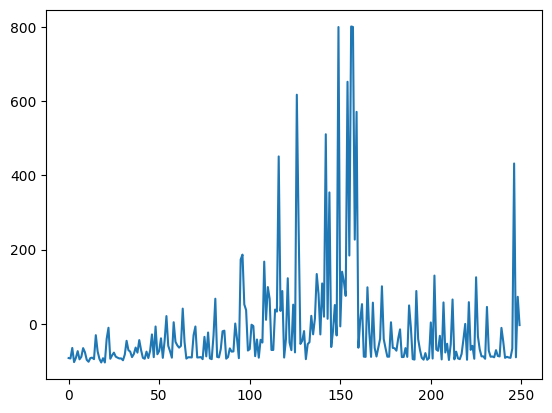

In [ ]:
epochs = 250
episode_limit = 800
hidden_size = 128
hidden_size_final = 64
results_dqn = dqn_main(epochs, episode_limit, hidden_size, hidden_size_final, 500)
plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()

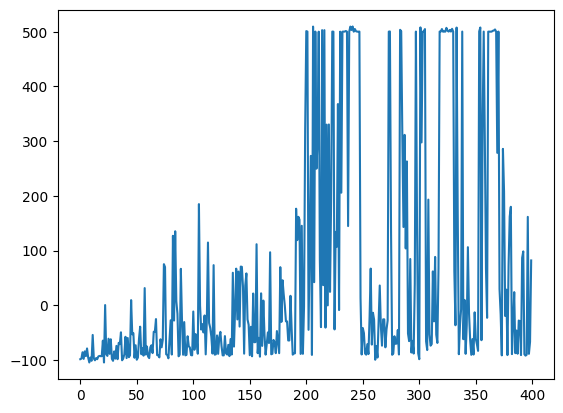

In [ ]:
epochs = 400
episode_limit = 500
hidden_size = 64
hidden_size_final = 32
results_dqn = dqn_main(epochs, episode_limit, hidden_size, hidden_size_final, 500)
plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()

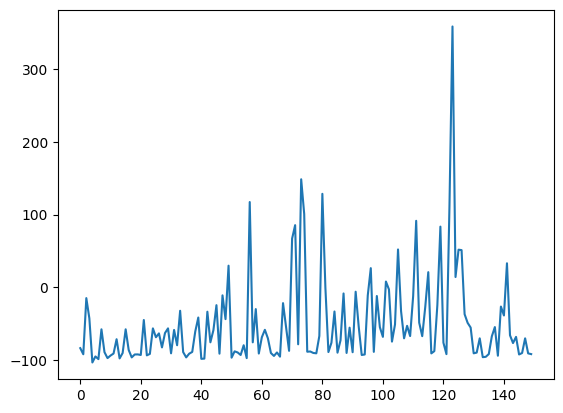

In [ ]:
epochs = 150
episode_limit = 10000
hidden_size = 128
hidden_size_final = 64
results_dqn = dqn_main(epochs, episode_limit, hidden_size, hidden_size_final, 500)
plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()

In [ ]:
epochs = 300
episode_limit = 10000
hidden_size = 128
hidden_size_final = 64
results_dqn = dqn_main(epochs, episode_limit, hidden_size, hidden_size_final, 500)
plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()

Episodes: 258 Reward: -29.200000000000244:  86%|████████▋ | 259/300 [2:38:24<20:13, 29.59s/it]

After Env, Network, Train logic changes

In [ ]:
epochs = 500
episode_limit = 50000
hidden_size = 128
hidden_size_final = 64

q_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network.load_state_dict(q_network.state_dict())

results_dqn = dqn_main(q_network, target_network, epochs, episode_limit, hidden_size, hidden_size_final, 50, "normalized-nonDueling")

plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()


Episodes: 450 Reward: -1.0363636363636317 Best Reward So Far: 6073.836363636381:  90%|█████████ | 451/500 [4:55:53<36:27, 44.65s/it]

KeyboardInterrupt: 

After new reward logic

In [11]:
epochs = 450
episode_limit = 50000
hidden_size = 128
hidden_size_final = 64

q_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network.load_state_dict(q_network.state_dict())

results_dqn = dqn_main(q_network, target_network, epochs, episode_limit, hidden_size, hidden_size_final, 50, "normalized-nonDueling")

plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()


Episodes: 236 Reward: 165.7018181818176 Best Reward So Far: 1300.1545454545471:  53%|█████▎    | 237/450 [1:17:58<9:27:04, 159.74s/it]

KeyboardInterrupt: 

After new reward logic Again

In [22]:
epochs = 450
episode_limit = 50000
hidden_size = 128
hidden_size_final = 64

q_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network = QNetwork(8, 3, hidden_size, hidden_size_final, True).to(device)
target_network.load_state_dict(q_network.state_dict())

results_dqn = dqn_main(q_network, target_network, epochs, episode_limit, hidden_size, hidden_size_final, 50, "normalized-nonDueling-finalfinalRewardLogic")

plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()


Episodes: 351 Reward: 456.6181818181817 Best Reward So Far: 5882.436363636363:  78%|███████▊  | 352/450 [59:48<25:49, 15.81s/it]

KeyboardInterrupt: 

In [16]:

class DuelingQNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super().__init__()

        self.feature = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU()
        )

        self.value_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        q_vals = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_vals


In [ ]:
epochs = 2000
episode_limit = 50000
hidden_size = 128

q_network = DuelingQNetwork(8, 3, hidden_size).to(device)
target_network = DuelingQNetwork(8, 3, hidden_size).to(device)
target_network.load_state_dict(q_network.state_dict())

results_dqn = dqn_main(q_network, target_network, epochs, episode_limit, hidden_size, hidden_size_final, 50, "dueling")

plt.plot(results_dqn)
plt.savefig(f"q_net_{epochs}_{episode_limit}_plot.png")
plt.show()


Episodes: 562 Reward: 5863.909090909092 Best Reward So Far: 32895.25454545434:  28%|██▊       | 563/2000 [5:06:30<128:22:02, 321.59s/it] 